# Studi Kasus: Memprediksi Kelayakan Emisi Mobil

**Dataset:** fuel_consumption_custom_dirty.csv (6 Fitur + 1 Target)  
**Target (y):** Eco_Friendly  


In [111]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score


## A. Data Preparation dan Cleaning

### A.1. Muat & Inspeksi
Baca fuel_consumption_custom_dirty.csv. Tampilkan 7 baris random, .info(), dan jumlah baris duplikat.


In [112]:
df = pd.read_csv("fuel_consumption_final_dirty.csv")
display(df.sample(7))

print(df.info())
print(df.duplicated().sum())

,Model Year,Vehicle Class,Fuel Type,Engine Size(L),Cylinders,Fuel Consumption(Comb (mpg)),Eco_Friendly
321,2022,Pickup truck: Standard,X,3.3,6,24,0
255,2022,Minivan,X,3.6,6,24,0
122,2022,SUV: Standard,Z,4.4,8,18,0
69,2022,Minicompact,Z,6.0,12,17,0
794,2022,Minicompact,Z,3.0,6,22,0
302,2022,SUV: Standard,X,3.5,6,21,0
33,2022,suv: small,Z,2.0,4,30,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Model Year                    956 non-null    int64  
 1   Vehicle Class                 956 non-null    object 
 2   Fuel Type                     956 non-null    object 
 3   Engine Size(L)                956 non-null    float64
 4   Cylinders                     956 non-null    int64  
 5   Fuel Consumption(Comb (mpg))  956 non-null    int64  
 6   Eco_Friendly                  956 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 52.4+ KB
None
426


### A.2. Hapus Duplikat
Hapus semua baris yang terduplikasi.


In [113]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

### A.3. Cleaning Teks
Kolom Vehicle Class: Terdapat nilai yang tidak konsisten (misal: ' compact ', 'SUV_SMALL'). Standarkan nilainya (misal: 'Compact', 'SUV: Small').


In [114]:
df['Vehicle Class'] = (
    df['Vehicle Class']
    .astype(str)
    .str.strip()
    .str.replace('_', ' ')
    .str.title()
)

df['Vehicle Class'].unique()

array(['Compact', 'Suv: Small', 'Mid-Size', 'Minicompact',
       'Suv: Standard', 'Two-Seater', 'Subcompact',
       'Station Wagon: Small', 'Station Wagon: Mid-Size', 'Full-Size',
       'Pickup Truck: Small', 'Pickup Truck: Standard', 'Minivan',
       'Special Purpose Vehicle'], dtype=object)

### A.4. Cleaning Outlier/Error
Gunakan metode IQR (Interquartile Range) untuk mengidentifikasi outlier statistik. Ganti semua nilai outlier yang ditemukan dengan Median dari kolom Cylinders.



In [115]:
Q1 = df['Cylinders'].quantile(0.25)
Q3 = df['Cylinders'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
median_val = df['Cylinders'].median()

df.loc[(df['Cylinders'] < lower) | (df['Cylinders'] > upper), 'Cylinders'] = median_val

### A.5. Imputasi Nilai Hilang (NaN)
- **Kolom Fuel Type:** Imputasi nilai NaN menggunakan Modus (Mode).
- **Kolom Fuel Consumption(Comb (mpg)):** Imputasi nilai NaN menggunakan Median.


In [116]:
df['Fuel Type'] = df['Fuel Type'].fillna(df['Fuel Type'].mode()[0])

col_fc = 'Fuel Consumption(Comb (mpg))'
df[col_fc] = df[col_fc].fillna(df[col_fc].median())

## B. Visualisasi, Encoding, dan Persiapan Model

### B.1. Visualisasi
Buat Visual untuk melihat perbandingan jumlah Eco_Friendly (0 vs 1) berdasarkan Fuel Type. Berikan sedikit penjelasan!


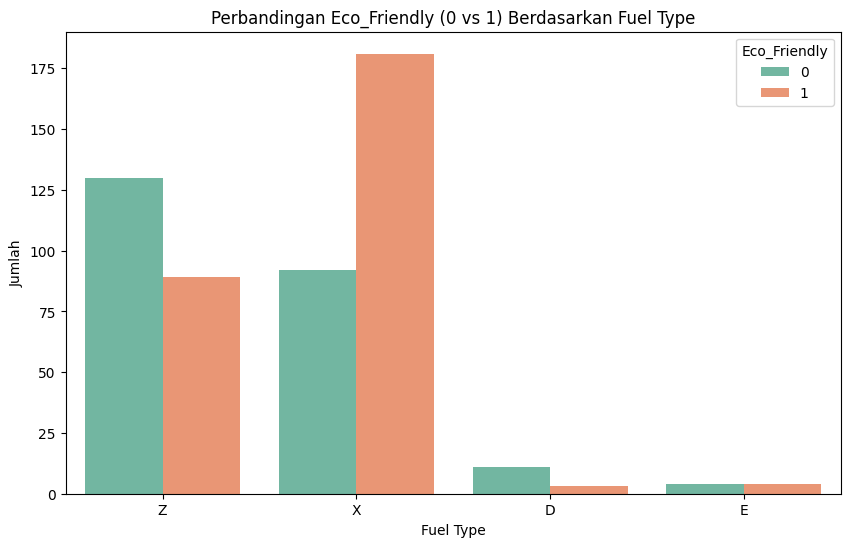

In [117]:
# Visualisasi perbandingan jumlah Eco_Friendly (0 vs 1)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_fuel, x='Fuel Type', hue='Eco_Friendly', palette='Set2')
plt.title('Perbandingan Eco_Friendly (0 vs 1) Berdasarkan Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Jumlah')
plt.legend(title='Eco_Friendly')
plt.show()


menurut saya distribusi kendaraan Eco_Friendly (1) dan tidak Eco_Friendly (0) pada setiap jenis bahan bakar. Grafik memperlihatkan bahwa beberapa jenis bahan bakar memiliki proporsi kendaraan ramah lingkungan yang lebih tinggi dibandingkan jenis lainnya, sehingga Fuel Type berpotensi memberikan pengaruh terhadap label Eco_Friendly dalam proses pemodelan

### B.2. Encoding
Lakukan One-Hot Encoding pada kolom kategorikal (Vehicle Class, Fuel Type).


In [118]:
df_encoded = pd.get_dummies(df, columns=['Vehicle Class', 'Fuel Type'], drop_first=True)
df_encoded.head()


,Model Year,Engine Size(L),Cylinders,Fuel Consumption(Comb (mpg)),Eco_Friendly,Vehicle Class_Full-Size,Vehicle Class_Mid-Size,Vehicle Class_Minicompact,Vehicle Class_Minivan,Vehicle Class_Pickup Truck: Small,...,Vehicle Class_Special Purpose Vehicle,Vehicle Class_Station Wagon: Mid-Size,Vehicle Class_Station Wagon: Small,Vehicle Class_Subcompact,Vehicle Class_Suv: Small,Vehicle Class_Suv: Standard,Vehicle Class_Two-Seater,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,2022,2.4,4,33,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2022,3.5,6,25,0,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,2022,2.0,4,29,1,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3,2022,2.0,4,27,1,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,2022,2.0,4,29,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### B.3. Seleksi Fitur & Target
- **X (Fitur):** Semua kolom numerik (Model Year, Engine Size(L), Cylinders, Fuel Consumption(Comb (mpg))). Tambahan **bonus** jika menggunakan kolom hasil One-Hot Encoding.
- **y (Target):** Kolom Eco_Friendly.


In [119]:
X = df[['Model Year', 'Engine Size(L)', 'Cylinders', 'Fuel Consumption(Comb (mpg))']]
y = df['Eco_Friendly']

print("Shape X:", X.shape)
print("Shape y:", y.shape)
X.head()

Shape X: (530, 4)
Shape y: (530,)


,Model Year,Engine Size(L),Cylinders,Fuel Consumption(Comb (mpg))
0,2022,2.4,4,33
1,2022,3.5,6,25
2,2022,2.0,4,29
3,2022,2.0,4,27
4,2022,2.0,4,29


### B.4. Split & Scale
Bagi data (70% latih, 30% uji) dan terapkan StandardScaler pada semua fitur numerik x.


In [120]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X train:", X_train_scaled.shape)
print("X test:", X_test_scaled.shape)

X train: (371, 4)
X test: (159, 4)


## C. Pemodelan dan Analisis

### C.1. Latih Model
Latih model Gaussian Naive Bayes dan Random Forest Classifier (n_estimators=100) pada data latih.


In [121]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### C.2. Evaluasi
Untuk kedua model, hitung Akurasi, Precision, dan F1-Score pada data uji.


In [122]:
print("Hasil Klasifikasi: ")
y_pred_nb = nb.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)
print("Naive Bayes Classifier:")
print(classification_report(y_test, y_pred_nb))
print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))
print("Akurasi Naive Bayes:", accuracy_score(y_test, y_pred_nb))
print("Akurasi Random Forest:", accuracy_score(y_test, y_pred_rf))


Hasil Klasifikasi: 
Naive Bayes Classifier:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        77
           1       0.81      0.74      0.78        82

    accuracy                           0.78       159
   macro avg       0.78      0.78      0.78       159
weighted avg       0.78      0.78      0.78       159

Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        77
           1       0.53      1.00      0.69        82

    accuracy                           0.54       159
   macro avg       0.76      0.53      0.40       159
weighted avg       0.76      0.54      0.40       159

Akurasi Naive Bayes: 0.779874213836478
Akurasi Random Forest: 0.5408805031446541


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### C.3. Kesimpulan 1
Berdasarkan soal C2, apa yang dapat disimpulkan? (markdown)


#### jawab disini 
Hasil evaluasi menunjukkan bahwa Naive Bayes memiliki performa lebih baik dibandingkan Random Forest, dengan akurasi sekitar 0.78 serta nilai precision, recall, dan F1-score yang lebih seimbang pada kedua kelas. Sebaliknya, Random Forest hanya mencapai akurasi sekitar 0.54 dan cenderung memprediksi sebagian besar data sebagai kelas 1, sehingga kinerjanya tidak stabil terutama pada kelas 0. Dengan demikian, Naive Bayes menjadi model yang lebih tepat untuk memprediksi label *Eco_Friendly* pada dataset ini.

### C.4. Analisis
Tampilkan Confusion Matrix untuk model yang hasilnya lebih baik.


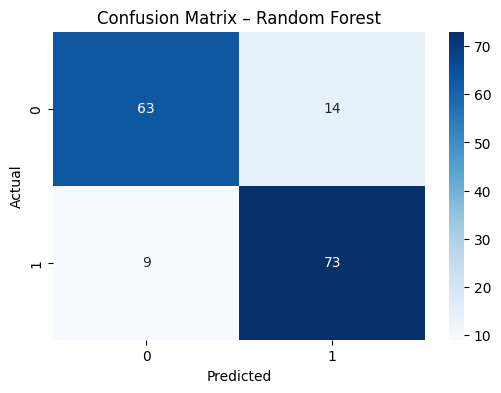

In [123]:
cm = confusion_matrix(y_test, pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()

### C.5. Kesimpulan 2
Berdasarkan soal C4, apa yang dapat disimpulkan? (markdown)

#### jawab disini
Model Random Forest menunjukkan performa yang cukup baik dan seimbang dalam mengenali kedua kelas. Dari total data uji, model berhasil memprediksi 63 data kelas 0 dan 73 data kelas 1 dengan benar. Kesalahan prediksi juga relatif kecil, yaitu 14 data kelas 0 salah diklasifikasi menjadi 1, serta 9 data kelas 1 salah diklasifikasi menjadi 0. Secara keseluruhan, model mampu membedakan kelas Eco_Friendly dan Non-Eco secara cukup akurat, meskipun masih terdapat beberapa kesalahan klasifikasi pada kedua kelas.

### **Bonus soal** :  Tuning model supaya menghasilkan hasil yang lebih baik (contoh tuning : ganti rasio splitting, n_estimators, maxdepth, dll), lalu jelaskan dalam markdown